In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.exceptions import UndefinedMetricWarning
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore', category=UndefinedMetricWarning)


np.random.seed(1234)

# Read data from training set

In [2]:
data = pd.read_csv('train_data.csv')
data_test = pd.read_csv('test_data.csv')
data.head()

,age,gender,asbestos exposure,duration of asbestos exposure,cytology,duration of symptoms,dyspnoea,ache on chest,weakness,performance status,...,type of MM_0.0,type of MM_1.0,type of MM_2.0,keep side_0,keep side_1,keep side_2,habit of cigarette_0,habit of cigarette_1,habit of cigarette_2,habit of cigarette_3
0,50.0,1,0,0.0,0,12.0,0,1,0,1,...,1,0,0,1,0,0,0,0,1,0
1,44.0,0,1,10.0,0,2.0,1,1,1,1,...,1,0,0,0,1,0,1,0,0,0
2,66.0,1,1,41.0,0,9.0,1,1,0,0,...,1,0,0,0,1,0,0,0,1,0
3,68.0,0,1,43.0,0,7.0,1,0,0,1,...,1,0,0,0,1,0,1,0,0,0
4,57.0,1,1,41.0,0,3.0,0,1,1,0,...,1,0,0,0,1,0,0,1,0,0


# Create handles for test and training data

In [3]:
data_continuous = data.loc[:, data.apply(lambda x: x.nunique()) > 2]
continuuous_features = data_continuous.columns

data_categorical = data.drop(continuuous_features, axis=1)
continuous_names = data_continuous.columns[:]
categorical_names = data_categorical.columns[:]

data_independent = data.drop(['class of diagnosis'], axis=1)
data_dependent = data['class of diagnosis']

data_test_independent = data_test.drop(['class of diagnosis'], axis=1)
data_test_dependent = data_test['class of diagnosis']

# Prepare data for SVM model

In order to improve the SVM's performance we normalize each column containing continuous features such that mean of each such column is equal to 0 and variance is equal to 1. In order to not lose any information, test data set has to be normalized according to the data from the __training__ set.

In [4]:
mean = data_independent[continuous_names].mean()
std = data_independent[continuous_names].std()

data_test_independent[continuous_names] -= mean
data_test_independent[continuous_names] /= std

data_independent[continuous_names] -= mean
data_independent[continuous_names] /= std

# Hyper parameter tuning

Since general SVC doesn't work good with linear kernel I use separate function to create a model using such kernel(LinearSVC).

In [5]:
grid_parameters = {
    'C': [.00001, .0001, .001, .01, .1, 1, 10, 100, 1000, 
          10000, 100000, 1000000, 10000000, 10000000],
    'loss': ['hinge', 'squared_hinge'],
}

svc = svm.LinearSVC()
clf = GridSearchCV(svc, grid_parameters, cv=5, scoring='f1')
clf = clf.fit(data_independent, data_dependent)


### Evaluation of linear model

In [6]:
print('Parameters of the best estimator :', end=' ')
print(clf.best_params_, end='\n\n')

prediction = clf.predict(data_test_independent)

print(classification_report(data_test_dependent, prediction))

Parameters of the best estimator : {'C': 10000, 'loss': 'hinge'}

             precision    recall  f1-score   support

          0       0.75      0.90      0.82        50
          1       0.00      0.00      0.00        15

avg / total       0.58      0.69      0.63        65



We can conclude that, in this case, linear kernel is not a good predictor. Now we check the performance of the models using non-linear kernel - radial basis function. 

### Non-linear model

In [7]:
grid_parameters = {
    'C': [.01, .1, 1, 10, 100, 1000, 10000, 100000, 1000000, 
          10000000, 10000000],
    'kernel': ['rbf'],
    'gamma': [.0001, .001, .01, .1, 1, 10],
}

clf = GridSearchCV(svm.SVC(probability=True), grid_parameters, cv=5,
                   scoring='f1')
clf.fit(data_independent, data_dependent)

estimator = clf.best_estimator_
prediction = estimator.predict(data_test_independent)
predict_prob = estimator.predict_proba(data_test_independent)

Pratameters of the best estimator: 
{'C': 100000, 'gamma': 0.001, 'kernel': 'rbf'}

             precision    recall  f1-score   support

          0       0.83      0.78      0.80        50
          1       0.39      0.47      0.42        15

avg / total       0.73      0.71      0.72        65



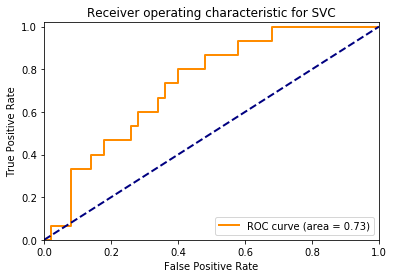

In [8]:
print('Pratameters of the best estimator: ')
print(clf.best_params_, end='\n\n')
print(classification_report(data_test_dependent, prediction))

fpr, tpr, thresholds = roc_curve(data_test_dependent, predict_prob.T[1])

plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for SVC')
plt.legend(loc="lower right")
plt.show()